In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import os
import math
import codecs
from collections import Counter
from nltk import word_tokenize,sent_tokenize
from gensim.models import Word2Vec
import spacy
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm


from feature_extraction import TextFeatureCreator

def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

In [2]:
#import zipfile
#zip_ref = zipfile.ZipFile("clean_newsela_article_files.zip", 'r')
#zip_ref.extractall("clean_newsela")
#zip_ref.close()

In [4]:
nlp = spacy.load('en_core_web_sm')

# Attention Based Neural Networks

## Import Section

### Dataset

In [4]:
#import training and test set
df = pd.read_csv("/data/ts_cost_function/newsela_article_feature_scores_V2.csv",sep=";")
df = df.loc[~df["path"].str.contains("LSAT")]
len(df)

21490

### Text Scorer

In [5]:
#import Scorer
ts = TextFeatureCreator("/data/ts_cost_function/LSATtexts.txt")

In [6]:
ts.feature_max

array([4.60611227e+00, 3.10202027e+01, 3.18078798e-01, 4.72160037e+01,
       4.57929050e-01, 7.43301324e+00, 4.42320513e+00, 2.82743677e+00,
       1.52766676e+00, 1.39530366e+00, 1.08050328e+00, 6.62886357e-01,
       1.08484166e+00, 1.20740261e-01, 3.11994654e-01, 1.65647696e-02,
       1.52961211e+00, 1.98660670e-01, 3.44356431e+00, 3.82638558e+00])

## Explore Dataset

### Number of different Tokens

In [7]:
test_path = "/data/ts_cost_function/clean_newsela/"
#test_path = test_path[:5] + "clean_" + test_path[5:]

In [8]:
def yield_file_text(df):
    for ind,row in df.iterrows():
        if row["path"] != 'data/LSATtexts.txt':
            yield get_file_text(row,tokenize=False)

In [9]:
def get_file_text(row,tokenize=True):
    path = row["path"].split("/")[-1]
    path= "/data/ts_cost_function/clean_newsela/"+path
    #if row["dataset"] == "newsela":
    #    path = row["path"][:5] + "clean_" + row["path"][5:]
    with codecs.open(path, "r",encoding='utf-8', errors='ignore') as f:
        text = f.read()
        if tokenize:
            text = [[word.text.lower() for word in nlp(sent)] for sent in text.split(".")]
        return text

In [10]:
def load_eng_words(eng_words_path="data/20k_words.txt"):

    with open(eng_words_path,"r") as f:
        data = f.read()
        words = data.split("\n")
        english_df = pd.DataFrame(data=words,columns=["word"])
        english_df["index"] = range(0,len(english_df))
    return english_df

In [ ]:
texts = [get_file_text(row) for ind,row in tqdm(df.iterrows()) if row["path"] != 'data/LSATtexts.txt']

In [ ]:
#word_set = set()
counter = Counter()
for ind,row in tqdm(df.iterrows()):
    lem_text = [token.lemma_ for token in nlp(get_file_text(row))]
    counter.update(lem_text)

In [23]:
with open("data/newsela_word_set.txt","w") as f:
    f.write(",".join(word_set))
    f.close()

In [47]:
word_array = np.array(list(word_set))
english_df = load_eng_words()
len(word_set.intersection(english_df["word"].values))

15419

### Number of Sentences and Words per Sentence

In [11]:
def sentence_stats(df):
    sents = []
    words = []
    removed = []
    for ind,text in enumerate(yield_file_text(df)):
        sent_split = sent_tokenize(text)
        sents.append(len(sent_split))
        words.append([word_tokenize(sent) for sent in sent_split])
        if text.find("This article has been removed") >= 0:
            removed.append(ind)
    
    print("Max #Sents: {}".format(np.max(sents)))
    print("Min #Sents: {}".format(np.min(sents)))
    print("Std #Sents: {}".format(np.std(sents)))
    plt.boxplot(sents)
    plt.show()
    
    return sents,words,removed

Max #Sents: 204
Min #Sents: 11
Std #Sents: 12.270055057859112


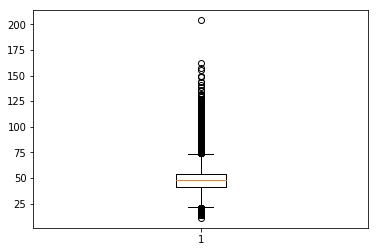

In [37]:
sents,words,removed = sentence_stats(df)

In [41]:
#Max Word Count
np.max([np.max(article) for article in words])

ValueError: zero-size array to reduction operation maximum which has no identity

In [110]:
#Mean Word Count
np.mean([sent for art in words for sent in art])

14.720281280318863

# Input Data

## Add lemmatize text to feature scores

In [65]:
def create_dataset_file(df,transform_fn,tokenize=False):
    df["text"] = df.apply(lambda row: transform_fn(get_file_text(row,tokenize)),axis=1)
    return df["text"]

In [66]:
def lemmatize_text(text):
    lemma_text=[]
    lemma_sent = []
    for token in nlp(text.lower()):
        if token.is_sent_start == True:
            lemma_text.append(lemma_sent)
            lemma_sent = []
        if token.lemma_ != "-PRON-":
            lemma_sent.append(token.lemma_)
        else:
            lemma_sent.append(token.text)
    return lemma_text
    

In [ ]:
df["text"] = create_dataset_file(df,lemmatize_text,False)

In [123]:
df.to_csv("/data/ts_cost_function/dataset_features_and_text.csv",index=False,sep="|")

## Word Embedding

In [5]:
df = pd.read_csv("/data/ts_cost_function/dataset_features_and_text.csv",sep="|")

### train word2vec

In [7]:
def prepare_sent_for_word2vec(text_list):
    text_parts,text_part = [],[]
    text_part_len = 0
    for text in text_list:
        text_len = len(text)
        if text_part_len + text_len < 900000:
            text_part_len += text_len
            text_part += [text]
        else:
            text_parts += [" ".join(text_part)]
            text_part_len = 0
            text_part = []
    return text_parts
    

In [ ]:
text_list = df["text"].values
text_parts = prepare_sent_for_word2vec(text_list)

hole_lem_text = [lemmatize_text(text) for text in tqdm(text_parts)]
hole_text_sents = np.concatenate(hole_lem_text)

In [104]:
lem_word2vec_model = Word2Vec(hole_text_sents, size=50, window=4, min_count=5)

In [107]:
lem_word2vec_model.save("/data/ts_cost_function/word2vec_lem.model")

In [109]:
lem_word2vec_model.wv["do"]

array([ 1.2452955 , -2.1530788 ,  1.7280709 , -0.9999138 , -1.1060853 ,
        0.3383382 , -1.1418934 ,  2.2745516 , -0.2513405 , -0.82757384,
       -0.7249763 ,  1.7150258 ,  2.44857   , -3.9633307 , -1.7148128 ,
       -0.02097538,  4.4459324 ,  0.41563603,  0.43043882, -0.21437858,
       -2.0976083 ,  3.0210202 ,  0.19070254,  2.732013  , -0.02442212,
        3.6682212 ,  0.86653304,  1.7804645 , -0.8916921 ,  2.6753292 ,
       -0.75225073, -2.1348693 ,  1.1207342 , -1.9519628 ,  1.996752  ,
       -2.7731352 ,  1.3074355 ,  3.1944182 , -2.046747  , -0.01732185,
       -0.9517765 ,  0.7973166 ,  0.5044691 , -1.0322701 ,  3.7471695 ,
       -0.25170118,  2.2080932 , -3.2449086 , -3.4603064 , -0.67942697],
      dtype=float32)

## Exchange lemmatized text by word2vec vectors

In [24]:
df = pd.read_csv("/data/ts_cost_function/dataset_features_and_text.csv",sep="|")
df.head()

,path,feature_sums,regression_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,...,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,text
0,/data/ts_cost_function/clean_newsela/kea-extin...,7.687178,0.326461,0.909090,0.306252,1.298557,0.263046,0.845914,0.365935,0.465726,...,0.603422,0.202795,0.000000,0.256415,0.0,0.366106,0.201348,0.203278,0.256116,"[['one', 'of', 'the', 'big', 'threat', 'to', '..."
1,/data/ts_cost_function/clean_newsela/australia...,16.690378,0.769983,0.995979,0.841234,1.016792,0.804812,1.071948,1.044247,0.968916,...,1.234272,0.796094,1.129397,0.437070,0.0,0.950924,0.686415,0.712792,0.855305,"[['drone', 'help', 'keep', 'swimmer', 'and', '..."
2,/data/ts_cost_function/clean_newsela/city-trol...,8.278258,0.352503,0.955849,0.313058,1.250405,0.273918,0.879494,0.373708,0.457185,...,0.360741,0.240468,0.180049,0.278712,0.0,0.440578,0.437714,0.183076,0.306794,"[['a', 'california', 'company', 'have', 'make'..."
3,/data/ts_cost_function/clean_newsela/parkland-...,12.440091,0.538971,0.846982,0.603712,0.943163,0.505093,0.689046,0.619676,0.733049,...,1.106273,0.442461,1.325159,0.128207,0.0,0.496858,0.805393,0.391068,0.282251,"[['the', 'drama', 'teacher', 'at', 'the', 'par..."
4,/data/ts_cost_function/clean_newsela/nyc-elect...,9.679800,0.476461,0.947809,0.433960,1.017136,0.382856,0.848541,0.602820,0.547810,...,0.551202,0.372263,0.637095,0.493105,0.0,0.440031,0.290406,0.379750,0.316627,"[['he', 'be', 'the', 'first', 'democrat', 'to'..."


In [19]:
lem_word2vec_model = Word2Vec.load("/data/ts_cost_function/word2vec_lem.model")

In [27]:
def text_to_vector(word2vec_model,text):
    vectorized_text = [
            [word2vec_model.wv[word] 
             for word in sent if word in lem_word2vec_model.wv.vocab] 
         for sent in text]
    
    #print(vectorized_text)
    vectorized_text = [sent for sent in vectorized_text if sent]
    return vectorized_text

In [28]:
vectorized_texts = df.apply(lambda x: text_to_vector(lem_word2vec_model,x["text"]),axis=1)

In [29]:
df["embed"] = vectorized_texts
df.head()

,path,feature_sums,regression_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,...,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,text,embed
0,/data/ts_cost_function/clean_newsela/kea-extin...,7.687178,0.326461,0.909090,0.306252,1.298557,0.263046,0.845914,0.365935,0.465726,...,0.202795,0.000000,0.256415,0.0,0.366106,0.201348,0.203278,0.256116,"[['one', 'of', 'the', 'big', 'threat', 'to', '...","[[[1.9871944, -1.6667207, 0.49945897, -0.74553..."
1,/data/ts_cost_function/clean_newsela/australia...,16.690378,0.769983,0.995979,0.841234,1.016792,0.804812,1.071948,1.044247,0.968916,...,0.796094,1.129397,0.437070,0.0,0.950924,0.686415,0.712792,0.855305,"[['drone', 'help', 'keep', 'swimmer', 'and', '...","[[[1.9871944, -1.6667207, 0.49945897, -0.74553..."
2,/data/ts_cost_function/clean_newsela/city-trol...,8.278258,0.352503,0.955849,0.313058,1.250405,0.273918,0.879494,0.373708,0.457185,...,0.240468,0.180049,0.278712,0.0,0.440578,0.437714,0.183076,0.306794,"[['a', 'california', 'company', 'have', 'make'...","[[[1.9871944, -1.6667207, 0.49945897, -0.74553..."
3,/data/ts_cost_function/clean_newsela/parkland-...,12.440091,0.538971,0.846982,0.603712,0.943163,0.505093,0.689046,0.619676,0.733049,...,0.442461,1.325159,0.128207,0.0,0.496858,0.805393,0.391068,0.282251,"[['the', 'drama', 'teacher', 'at', 'the', 'par...","[[[1.9871944, -1.6667207, 0.49945897, -0.74553..."
4,/data/ts_cost_function/clean_newsela/nyc-elect...,9.679800,0.476461,0.947809,0.433960,1.017136,0.382856,0.848541,0.602820,0.547810,...,0.372263,0.637095,0.493105,0.0,0.440031,0.290406,0.379750,0.316627,"[['he', 'be', 'the', 'first', 'democrat', 'to'...","[[[1.9871944, -1.6667207, 0.49945897, -0.74553..."


### Use predefined word embedding

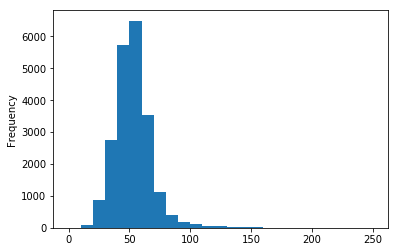

In [235]:
test_len = df.apply(lambda x: len(x["embed"]),axis=1)
test_len.plot.hist(bins=range(0,260,10))

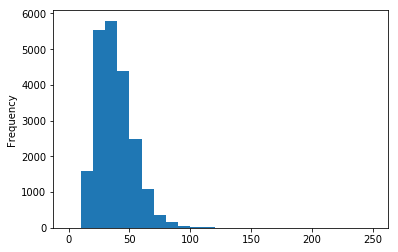

In [242]:
sent_lens = df.apply(lambda x: [len(sent) for sent in x["embed"]],axis=1)
max_sent_len = sent_lens.apply(lambda x: np.max(x))
max_sent_len.plot.hist(bins=range(0,260,10))

In [13]:
def embed_padding(embed,max_sent,max_word,embed_size):
    result = np.zeros((max_sent,max_word,embed_size))
    for sent_ind,sent in enumerate(embed[:max_sent]):
        for word_ind,word in enumerate(sent[:max_word]):
            result[sent_ind,word_ind] = word
    return result

In [34]:
df["embed_pad"] = df.apply(
        lambda x: embed_padding(
            x["embed"],
            100,
            100,
            50),
        axis=1)

In [ ]:
np.save('/data/ts_cost_function/embed_pad.npy', df["embed_pad"])

In [37]:
def define_word_embed_input_fn(df,batch_size,epochs):

    return tf.estimator.inputs.pandas_input_fn(
        df[["embed_pad"]],
        y=df["regression_score"],
        batch_size=batch_size,
        num_epochs=epochs,
        shuffle=True,
        queue_capacity=1000,
        num_threads=1,
        target_column=None
    )

In [ ]:
func()

In [43]:
func = define_word_embed_input_fn(df,10,1)
features_op, labels_op = func()
with tf.Session() as sess:
    # initialise and start the queues.
    sess.run(tf.local_variables_initializer())

    coordinator = tf.train.Coordinator()
    _ = tf.train.start_queue_runners(coord=coordinator)

    print(sess.run([features_op, labels_op]))

KeyError: None

In [321]:
def train_word_emb_fn(df,batch_size,max_sent,max_word,embed_size):
    
    dataset = tf.data.Dataset.from_tensor_slices((dict(df["embed_pad"]), df["regression_score"]))
    
    
    #dataset = tf.data.Dataset.from_generator(lambda:
    #    df[["regression_score"]].iterrows(), tf.float32, output_shapes=[None])

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)
    #shuffle(1000)
    
    # Return the dataset.
    return dataset

In [ ]:
dataset = train_word_emb_fn(df,10,205,400,50)

In [303]:
dataset_iter = dataset.make_one_shot_iterator()

In [304]:
sess = tf.Session()
result = sess.run(dataset_iter.get_next())

In [305]:
result

array([[0.        , 0.32646066],
       [1.        , 0.7699827 ],
       [2.        , 0.35250273],
       [3.        , 0.5389706 ],
       [4.        , 0.47646102],
       [5.        , 0.5271396 ],
       [6.        , 0.37357196],
       [7.        , 0.34534666],
       [8.        , 0.70348585],
       [9.        , 0.29645792]], dtype=float32)

In [ ]:
def eval_word_emb_fn(features, labels=None, batch_size=None):
    """An input function for evaluation or prediction"""
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert inputs to a tf.dataset object.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()

## Sentence Words

## Character Level

# NN Architecture

## Embedding + Sentence RNN + Text RNN

The sentence RNN will output a hidden state for each sentence. Afterwards each hidden state will be used as a input for another RNN on text level. The final output is than the score.

In [ ]:
def model_emb_cnn_rnn_fn(features, labels, mode):
    
    input_layer = 

## Embedding + Conv + RNN

Taghipour, Kaveh, and Hwee Tou Ng. "A neural approach to automated essay scoring." Proceedings of the 2016 Conference on Empirical Methods in Natural Language Processing. 2016.

![alt text](A_Neural_Approach_to_Automated_Essay_Scoring.PNG)

In [ ]:
def model_emb_cnn_rnn_fn(features, labels, mode):
    """Model function for CNN."""
    # features = words
    input_layer = tf.reshape(features, [-1, 28, 28, 1])

    # Convolutional Layer #1
    #conv1 = tf.layers.conv2d(
    #  inputs=input_layer,
    #  filters=32,
    #  kernel_size=[3, 3],
    #  padding="same",
    #  activation=tf.nn.relu)
    
    conv1_layer = tf.layers.Conv2D(
        filters=32,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name="conv1_layer"
    )
    conv1 = conv1_layer.apply(input_layer)
    
    #weights = conv1_layer.trainable_weights

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)
    
    softmax = tf.nn.softmax(logits, name="softmax_tensor")

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": softmax
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.005)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [ ]:
#Estimator

## 1D Conv Layer for Text Embedding


## Recurrent Layer with each Conv Layer Output as Input
## Output: Score

## Mean over time of all RNN scores

## Training

In [ ]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="tmp/mnist_convnet_model")


tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=2000)

tf.logging.set_verbosity(tf.logging.INFO)

In [ ]:
mnist_classifier.train(
    input_fn=lambda:train_input_fn(
        X_train,
        y_train,
        32),
    steps=2000,
    hooks=[logging_hook])

## Evaluation

In [ ]:
eval_results = mnist_classifier.evaluate(
    input_fn=lambda:eval_input_fn(X_test,y_test,len(X_test)))